In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime

In [2]:
#Utility functions
def millis_translation(ms_timestamp):
    timestamp_in_seconds = ms_timestamp / 1000
    dt_object = datetime.fromtimestamp(timestamp_in_seconds)
    formatted_date = dt_object.strftime('%y/%m/%d %H:%M')
    return str(formatted_date)
def format_okx_data(load):
    df = pd.DataFrame()
    df['Time'] = [millis_translation(int(i[0])) for i in load][::-1]
    df['O'] = [float(i[1]) for i in load][::-1]
    df['H'] = [float(i[2]) for i in load][::-1]
    df['L'] = [float(i[3]) for i in load][::-1]
    df['C'] = [float(i[4]) for i in load][::-1]
    df['Change'] = df['C'].pct_change()
    df = df.dropna()
    return df
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return round(mean / sigma,2)

In [3]:
class OKX:
    def __init__(self,exchange='OKX'):
        self.url = 'https://www.okx.com'
    def get_instruments(self):
        path = '/api/v5/public/instruments'
        params = {'instType':'SWAP'}
        response = requests.get(self.url+path,params).json()
        return response['data']
    def get_perps(self):
        instrus = self.get_instruments()
        universe = []
        for i in instrus:
            if i['instId'][-9:-5] == 'USDT':
                universe.append(i['instId'])
        return universe
    def get_ohlc(self,symbol,interval):
        path = '/api/v5/market/mark-price-candles'
        params = {'instId':symbol,'bar':interval}
        response = requests.get(self.url+path,params).json()['data']
        return response

In [4]:
tickers = OKX().get_perps()

In [5]:
dico = {}
interval = '4H'
for i in tickers : 
    dico[i] = format_okx_data(OKX().get_ohlc(i,interval))['Change']

In [6]:
data = pd.DataFrame(dico)
data = data.dropna(axis=1)

df = pd.DataFrame(dico)
df = df.dropna(axis=1)
df['Top Performers'] = [list(data.iloc[i].sort_values().keys()[-5::]) for i in range(len(df))]
df['Worst Performers'] = [list(data.iloc[i].sort_values().keys()[:5]) for i in range(len(df))]

In [7]:
perps = list(data.keys()) #tradable

In [8]:
top_perf = [0]
bottom_perf = [0]
top_temp_list = []
bottom_temp_list = []
for i in range(len(df)-1):
    for j in df['Top Performers'].iloc[i]:
        top_temp_list.append(df[j].iloc[i+1])
    top_perf.append(np.cumsum(np.array(top_temp_list))[-1]/5)
    top_temp_list = []
    for s in df['Worst Performers'].iloc[i]:
        bottom_temp_list.append(df[j].iloc[i+1])
    bottom_perf.append(np.cumsum(np.array(bottom_temp_list))[-1]/5)
    bottom_temp_list = []
        
        
long_array,short_array = np.array(top_perf),np.array(bottom_perf)

In [9]:
performance_df = pd.DataFrame()
performance_df['Top'] = long_array
performance_df['Bottom'] = short_array
performance_df['Top-Bottom'] = long_array-short_array

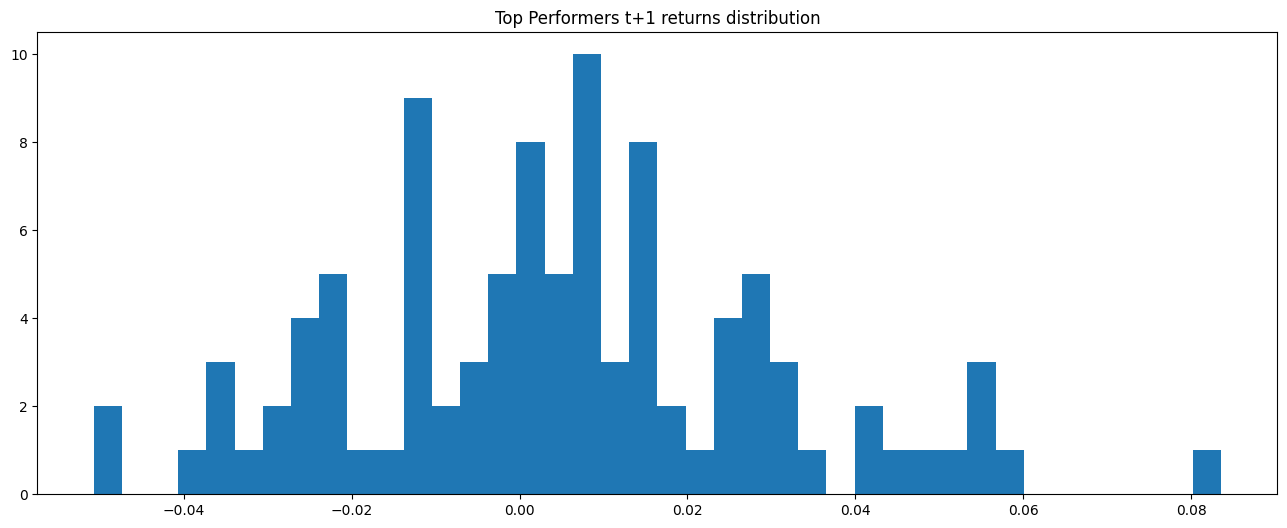

In [10]:
plt.figure(figsize=(16,6))
plt.title('Top Performers t+1 returns distribution')
plt.hist(long_array,bins=40)
plt.show()

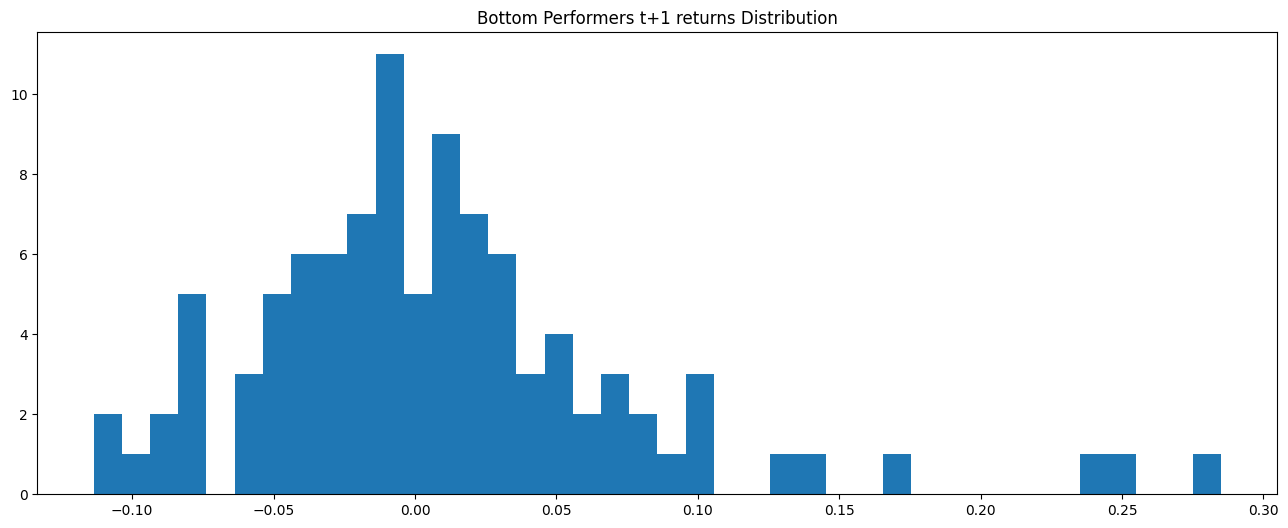

In [11]:
plt.figure(figsize=(16,6))
plt.title('Bottom Performers t+1 returns Distribution')
plt.hist(short_array,bins=40)
plt.show()

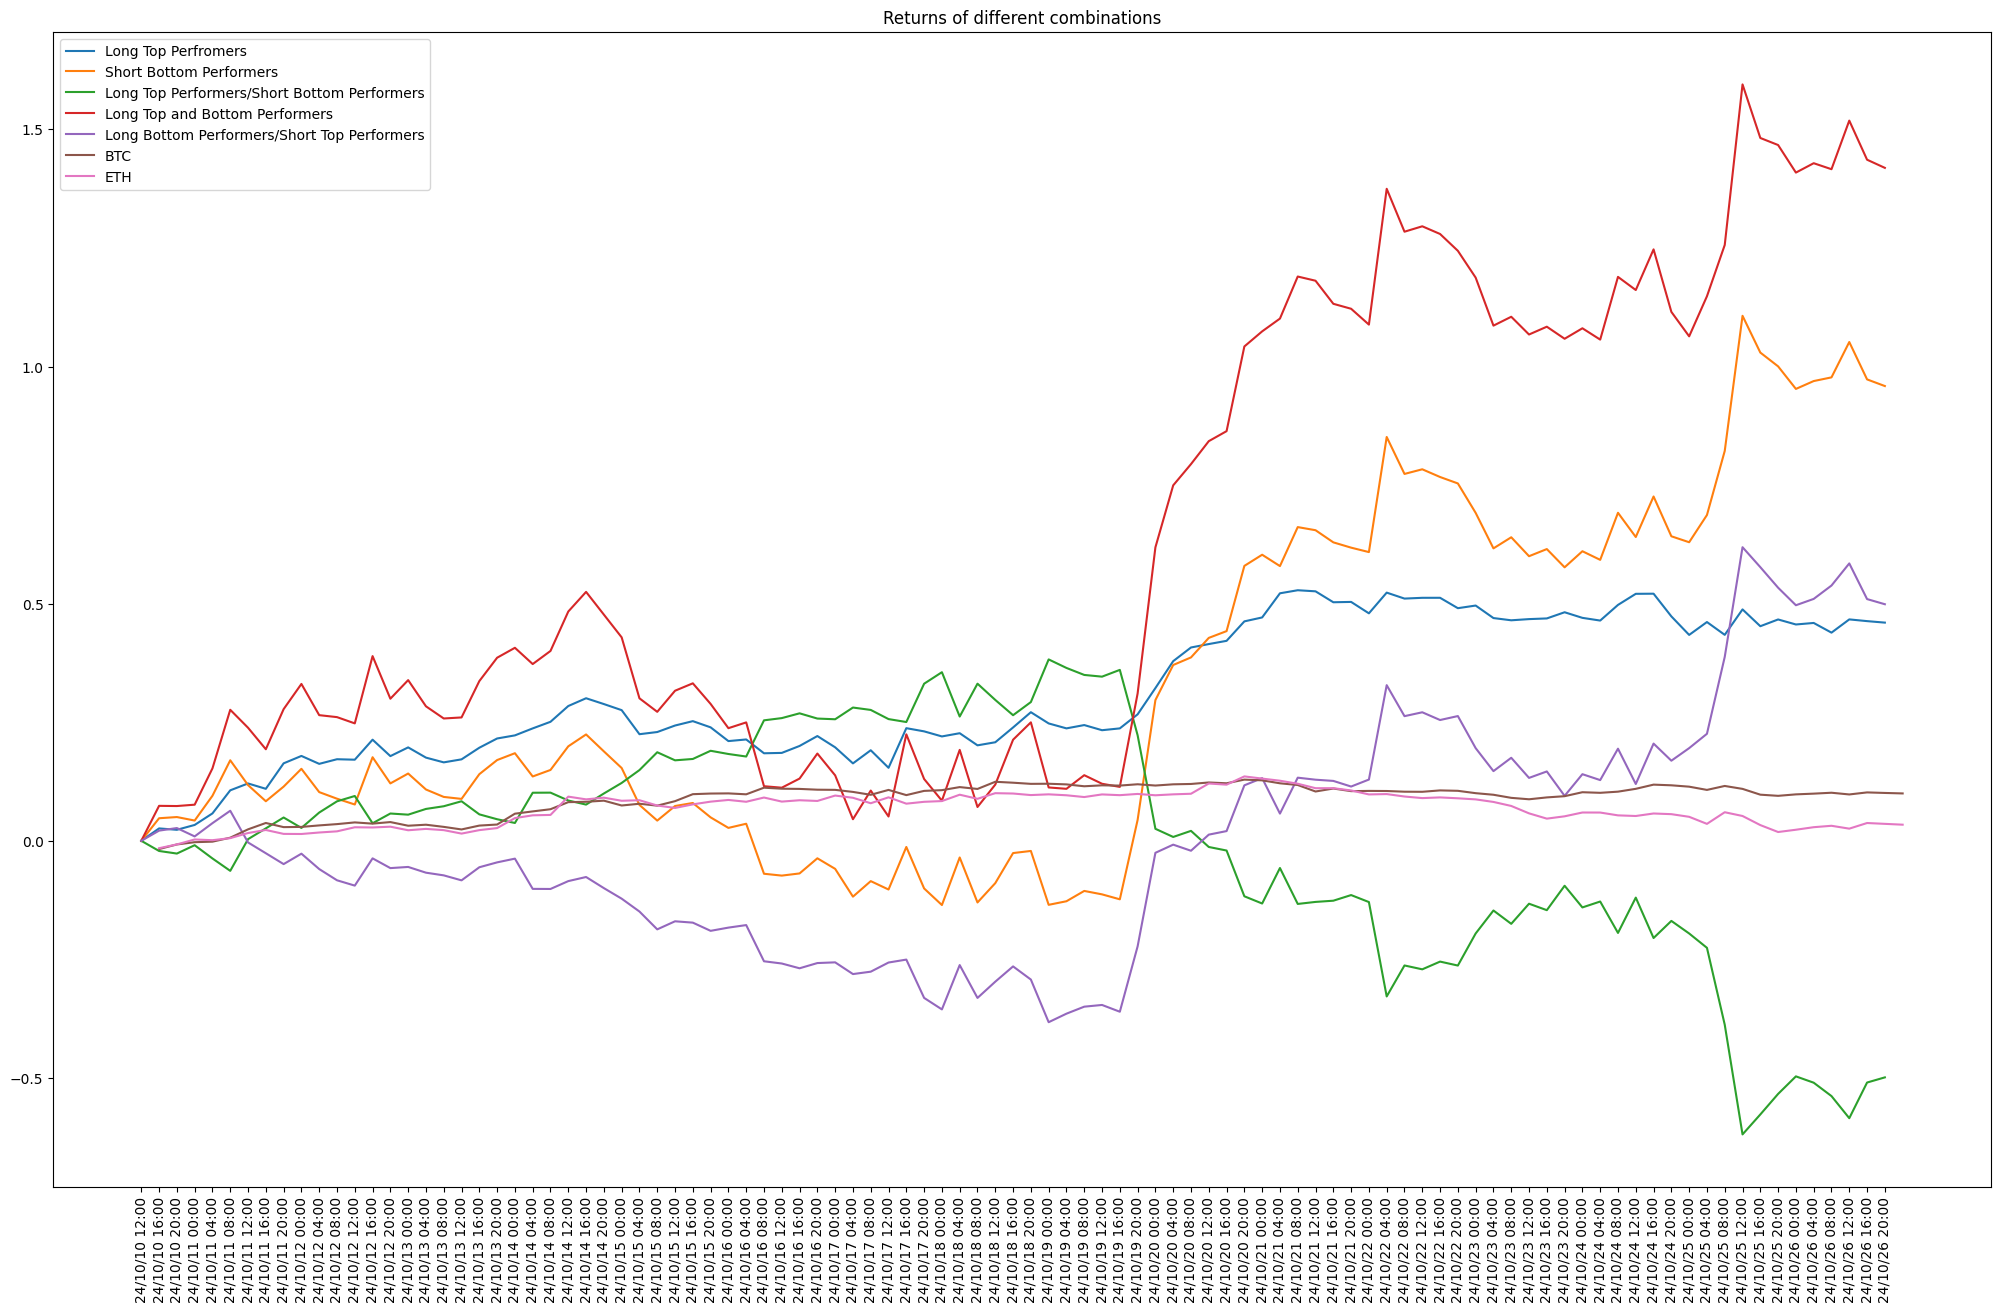

In [12]:
x = format_okx_data(OKX().get_ohlc('BTC-USDT-SWAP',interval))['Time']#[1::]
plt.figure(figsize=(25,15))
plt.title('Returns of different combinations')
plt.plot(x,np.cumsum(long_array),label='Long Top Perfromers')
plt.plot(x,np.cumsum(short_array),label='Short Bottom Performers')
plt.plot(x,np.cumsum(long_array-short_array),label='Long Top Performers/Short Bottom Performers')
plt.plot(x,np.cumsum(long_array+short_array),label='Long Top and Bottom Performers')
plt.plot(x,np.cumsum(short_array-long_array),label='Long Bottom Performers/Short Top Performers')
plt.plot(np.cumsum(df['BTC-USDT-SWAP']),label='BTC')
plt.plot(np.cumsum(df['ETH-USDT-SWAP']),label='ETH')
plt.xticks(rotation=90)
plt.legend()
plt.show()